# Installing the required packages

In [ ]:
!pip install pims
!pip install trackpy
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mounting the drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# We extract individial frames from the video

In [ ]:
import cv2
def get_frames():
    videoCapture = cv2.VideoCapture("/content/drive/Shareddrives/for_bs/BS_191/Bead_5V_500_Hz_Field001.mp4");
    success, frame = videoCapture.read();
    num_frames=0;
    print(success)
    # Create the frames from the given video
    while success:
        print(num_frames)
        # Saves the frames with frame-count
        if num_frames >=200 and num_frames<301 : 
          cv2.imwrite(r"/content/drive/Shareddrives/for_bs/BS_191/frames_5_bead/frame%d.tif" % num_frames, frame)
        num_frames += 1;   
        # print(frame.shape)  
        success, frame = videoCapture.read();
    return num_frames

count = get_frames()
print("The number of frames are:",count)

# Extract Dataframe containing features that represent the particle information

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series 

import pims
import trackpy as tp


# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray(image):
    return image[:, :, 1] #converts to greyscale 

frames = pims.open('/content/drive/Shareddrives/for_bs/BS_191/frames_5_bead/*.tif') # opens the folder containing all the tif files
# stores them as a measure of intensity 
new_frames=[]
for i in range(100):
  new_frames.append( gray(frames[i]))
#calls tp.locate on each frame and collects the results

f = tp.batch(new_frames[:100], 3, percentile=20, minmass=15)  # locates and results the characteristics of each particle
#f consists of 5 columns of data, one 'row' for each particle in the image. The numbers are (1) x-centroid (2) y-centroid (3) total brightness(mass) (4) radius of gyration and (5) 'eccentricity' which is 0 for circles and 1 for lines. 



Frame 99: 125 features


# Visualise the Crocker-Grier algorithm's tracking of the Beads

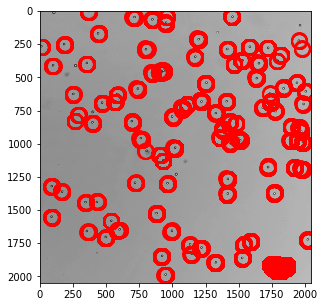

In [ ]:

tp.annotate(f,new_frames[0])

# We check the first 5 entirs of the dataframe

In [ ]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,38.972678,1441.016393,15.192657,0.887066,0.256944,3.237779,315.0,-0.031077,0
1,49.076142,714.979695,16.354937,0.881277,0.333333,3.652879,305.0,-0.030447,0
2,64.973545,850.931217,15.690777,0.872872,0.270833,3.735899,338.0,-0.032630,0
3,169.983696,442.956522,15.275677,0.881575,0.181818,3.403819,307.0,-0.030571,0
4,217.021505,1194.962366,15.441717,0.870669,0.326241,3.735899,323.0,-0.031600,0


# Final visualizations using trackpy

Frame 99: 125 trajectories present.


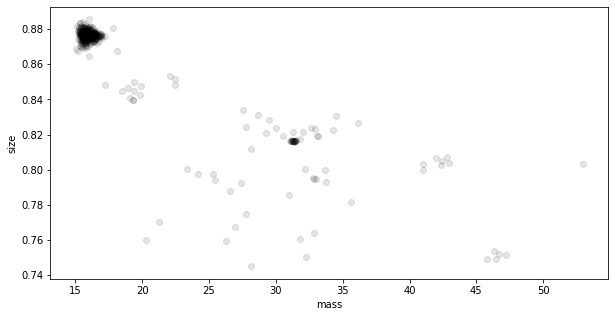

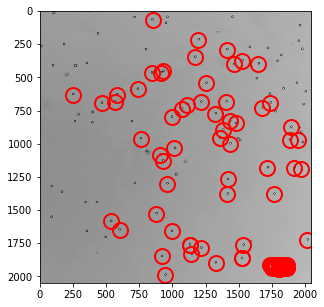

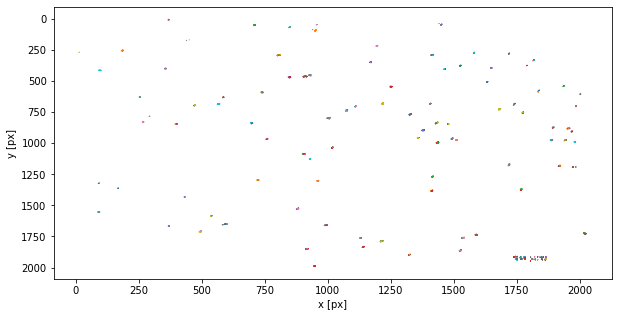

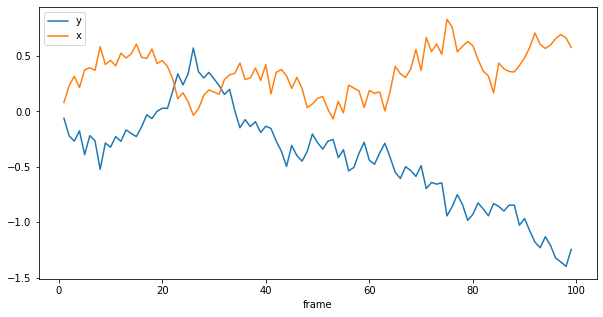

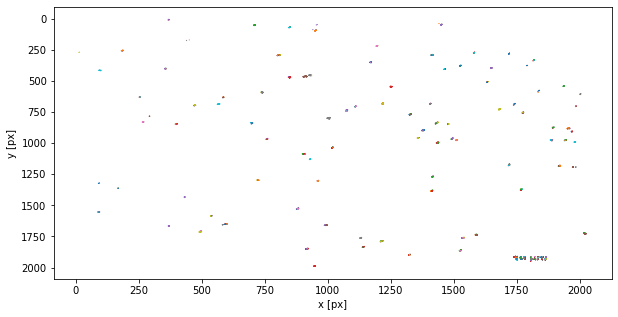

/usr/local/lib/python3.7/dist-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/usr/local/lib/python3.7/dist-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


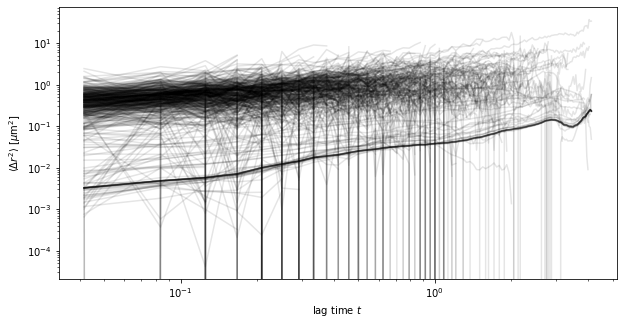

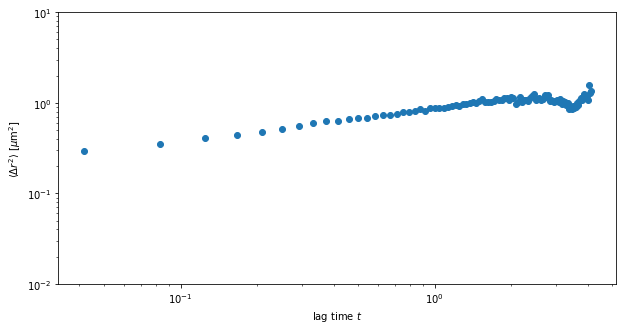

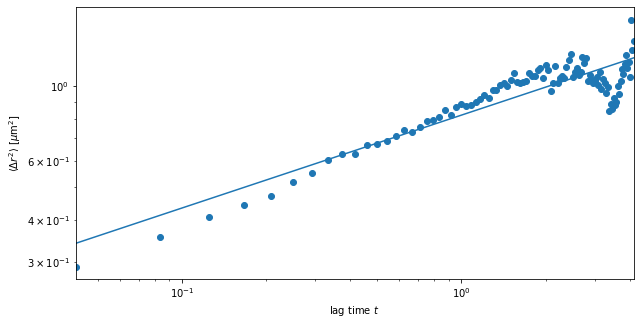

,n,A
msd,0.276672,0.820944


In [ ]:
t = tp.link(f, 5, memory=2) # define the max displacement (5)
t1 = tp.filter_stubs(t, 4) # removing particles that appear on only few frames
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # mean position of the particle

t2 = t1[((t1['mass'] > 10) & (t1['size'] < 0.9) &
         (t1['ecc'] < 0.5))]                  #filtering based on features 
tp.annotate(t2[t2['frame'] == 0], frames[0]);     

plt.figure()
tp.plot_traj(t2); 


d = tp.compute_drift(t2)
d.plot()
plt.show()

tm = tp.subtract_drift(t2.copy(), d)
ax = tp.plot_traj(tm)
plt.show()

im = tp.imsd(tm, 100/285., 24) # taking arbitrary values of microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

# finding the ensemble mean square displacement 
em = tp.emsd(tm, 100/285., 24)
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10))

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots

# References:

1. http://soft-matter.github.io/trackpy/v0.3.0/tutorial/walkthrough.html